In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tnrange, tqdm_notebook,tqdm
import matplotlib.pyplot as plt
def fff(ser):
    serr=ser.reset_index()
    serr['date']=serr.apply(lambda k: pd.Timestamp(year=int(k['level_0']),month=int(k['level_1']),day=1),1)
    return serr.drop(['level_0','level_1'],1)
pd.Series.fff=fff
plt.rcParams['font.sans-serif']=['SimHei']


In [2]:
ret=pd.read_csv('./TRD_Mnth.csv',sep='\t',dtype={'Stkcd':'str'})
ret.Trdmnt=pd.to_datetime(ret.Trdmnt)

combas=pd.read_csv('FS_Combas.csv',sep='\t',dtype={'Stkcd':'str'})
combas.Accper=pd.to_datetime(combas.Accper)

rm=pd.read_csv('TRD_Cnmont.csv',sep='\t')
rm.Trdmnt=pd.to_datetime(rm.Trdmnt)

idx=pd.read_csv('TRD_Index.csv',sep='\t',dtype={'Indexcd':'str'})
idx.Trddt=pd.to_datetime(idx.Trddt)

eps=pd.read_csv('FININD_FE03BEBA115_(1).csv',encoding='gbk',dtype={'A股股票代码_A_Stkcd':'str'})
eps.columns=['stkcd','date','eps','c']
eps=eps.drop(['c'],1)

eps.date=pd.to_datetime(eps.date)

tp=idx[idx.Indexcd=='000001']
tp=tp.Retindex.groupby([tp.Trddt.dt.year,tp.Trddt.dt.month]).sum()
tp.index=tp.index.rename(['level_0','level_1'])
idx=tp.fff()

ff3=pd.read_csv('ff3.csv',sep='\t',)
ff3.columns=['Trdmnt','RM','SMB','HML']

ff3.Trdmnt=pd.to_datetime(ff3.Trdmnt)

ff3=ff3.set_index('Trdmnt')

In [3]:
def get_g(year):#在每年的6月决定投资组合以及投资权重
    
    eps1=eps[eps.date.dt.year==year-1].set_index('stkcd').eps
    eps2=eps[eps.date.dt.year==year-2].set_index('stkcd').eps
    eps3=eps[eps.date.dt.year==year-3].set_index('stkcd').eps
    p=ret[(ret.Trdmnt.dt.year==year)& (ret.Trdmnt.dt.month==6)].set_index('Stkcd')['Mclsprc']
    pe=p/eps1
    growth=(eps1-eps3)/eps1
    
    PEG=pe/(growth*100)
    growing=PEG[(pe>0)&(growth>0)&(PEG<10)]

    #return values[growing[(growing.rank(pct=True)<0.5)].index]
    return growing.sort_values(ascending=True)


In [4]:
def get_value(year,g):
    values=ret[(ret.Trdmnt.dt.year==year)& (ret.Trdmnt.dt.month==6)].set_index('Stkcd')['Msmvosd']
    return values[g.index]

In [5]:
r=pd.DataFrame(index=pd.date_range(start='2005-06-01',end='2018-09-01',freq='M').map(
    lambda t:pd.Timestamp(year=t.year, month=t.month, day=1))
               ,columns=['rp','rm2'])

for date in tqdm_notebook( r.index):
    if date.month==6:
        g=get_g(date.year)
        weight=get_value(date.year,g)#选股
        
    
    in_month=ret[(ret.Trdmnt.dt.year==date.year)&(ret.Trdmnt.dt.month==date.month)]
    
    lis=set(weight.index).intersection(set(in_month.Stkcd))
    in_group=in_month[in_month.Stkcd.isin(lis)].set_index('Stkcd')
    a,b=(in_group.Mretwd , weight[weight.index.isin(lis)])
    r.loc[date,'rp']=(a*b/b.sum() ).sum()
    #r.loc[date,'rp']=a.mean() #直接按照等权重买入

    
    #计算市场收益率
    #r.loc[date,'rm1']=rm[(rm.Trdmnt.dt.year==date.year)&(rm.Trdmnt.dt.month==date.month)]['Cmretmdeq'].iloc[0]
    r.loc[date,'rm2']=idx[(idx.date.dt.year==date.year)&(idx.date.dt.month==date.month)]['Retindex'].iloc[0]

In [6]:
#r['10-1']=r[10]-r[1]
r

,rp,rm2
2005-06-01,0.027813,0.024433
2005-07-01,0.00159913,0.004139
2005-08-01,0.0850645,0.073244
2005-09-01,0.00116363,-0.004521
2005-10-01,-0.0465277,-0.054869
2005-11-01,-0.00576944,0.00677
2005-12-01,0.0589225,0.055235
2006-01-01,0.0981978,0.081129
2006-02-01,0.0385013,0.033023
2006-03-01,0.0165983,0.000277


In [29]:
plt.figure(figsize=(14,7))
a=r.rp[r.index.to_series().dt.year>2015]
r.rp.to_clipboard()
#sns.barplot(y=a,x=a.index,color='r')

<Figure size 1008x504 with 0 Axes>

In [6]:
t=(r+1).cumprod() #净值曲线

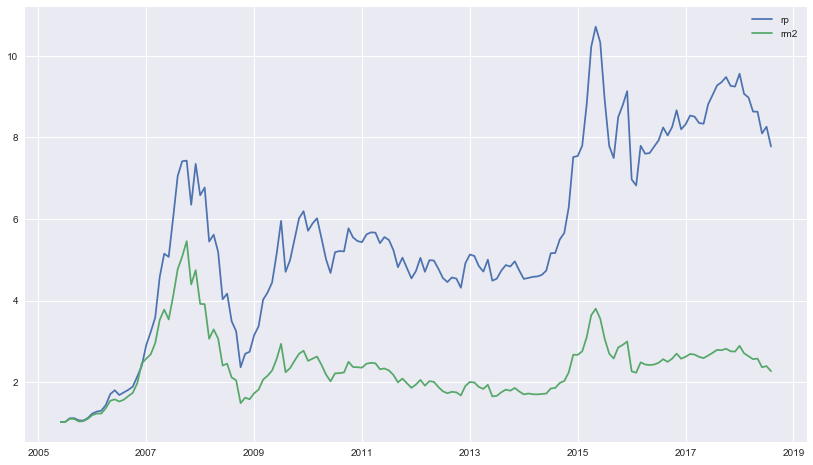

In [7]:
#sns.set_palette(sns.color_palette('deep'))#sns.color_palette("GnBu_d",10)+[(1,0,0)])
#sns.set()

f,axes=plt.subplots(1, 1, figsize=(14, 8), sharex=True) 
#sns.set_palette('RdBu')

tp=t.plot(figsize=(14,8),ax=axes)


In [7]:
def max_draw_down(ser):
    
    tt=ser.values
    i = np.argmax((np.maximum.accumulate(tt) - tt) / np.maximum.accumulate(tt))
    if i==0:
        return 0
    j = np.argmax(tt[:i]) 
    return (tt[j] - tt[i]) / (tt[j])
def sharpe(ser):
    sigma=ser.std()
    return ser.mean()/sigma

In [8]:


mdd=max_draw_down(t['rp'])
sp=sharpe(r['rp'])

print('标准差   \t:  {:.2}'.format(r['rp'].std()))
print('最大回撤 \t:  {:.2%}'.format(mdd))
print('夏普比率 \t:  {:.2%}'.format(sp))
print('总收益率 \t:  {:.2%}'.format(r['rp'].sum()) )
print('月均收益率 \t:  {:.2%}'.format(r['rp'].mean()))
print('年均收益率 \t:  {:.2%}'.format(r['rp'].mean()*12))

标准差   	:  0.086
最大回撤 	:  68.15%
夏普比率 	:  19.36%
总收益率 	:  266.18%
月均收益率 	:  1.67%
年均收益率 	:  20.09%


In [9]:
ys=r.index.to_series().dt.year
ms=r.index.to_series().dt.month

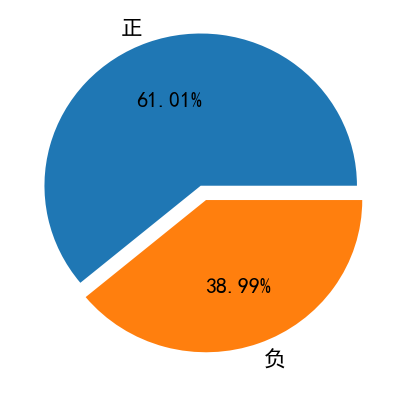

In [10]:
x=[(r.rp>0).sum(),(r.rp<0).sum()]
l=['正','负']
#sns.set()
plt.rc('font', family='SimHei', size=22)
plt.figure(figsize=(7,7))

tp=plt.pie(x,[0.1,0],labels=l,autopct='%3.2f%%')
x,sum(x)
plt.rc('font', family='SimHei', size=22)

In [11]:
x,l

([97, 62], ['正', '负'])

([112, 47], 159)

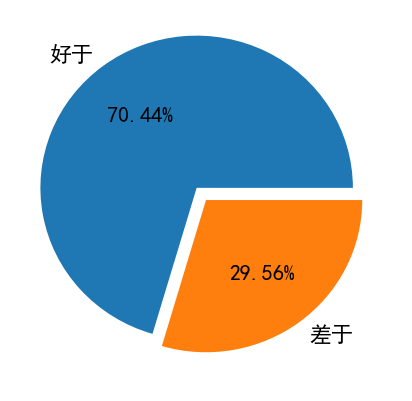

In [12]:
x=[(r.rp>r.rm2).sum(),(r.rp<r.rm2).sum()]
l=['好于','差于']
plt.figure(figsize=(7,7))
tp=plt.pie(x,[0.1,0],labels=l,autopct='%3.2f%%')
x,sum(x)

<Figure size 1008x504 with 0 Axes>

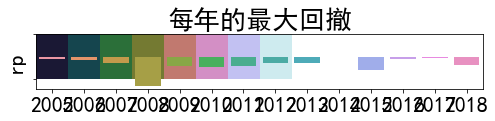

In [30]:
tp=t.groupby(ys)['rp'].apply(max_draw_down)
plt.figure(figsize=(14,7))
sns.palplot(sns.color_palette("cubehelix", 8))
tp=sns.barplot(y=tp,x=tp.index)

plt.rc('font', family='SimHei', size=22)
tp=plt.title('每年的最大回撤')
plt.rc('font', family='SimHei', size=12)

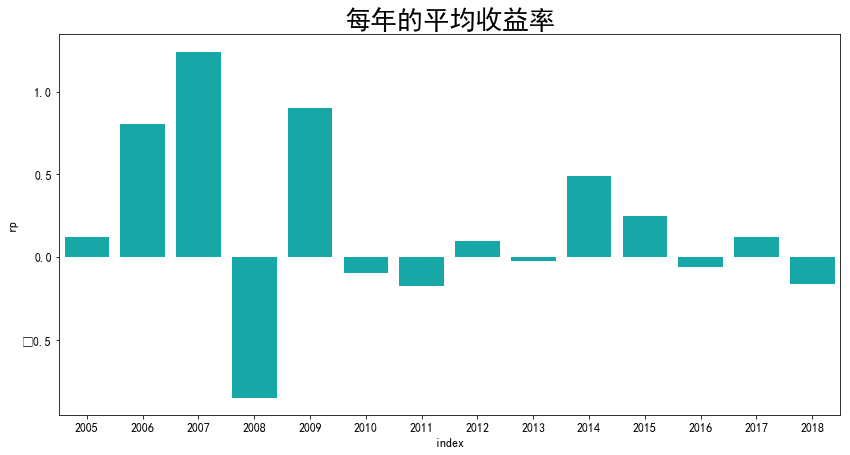

In [18]:
tp=r.groupby(ys).sum().reset_index()
#print(tp)
#sns.set(style="whitegrid")
plt.figure(figsize=(14,7))
#sns.set_color_codes("pastel")
sns.barplot(data=tp,x='index',y='rp',color='c')
#sns.set_color_codes("muted")
#sns.barplot(data=tp,x='index',y='rm2',color='r')
#plt.rc()
plt.rc('font', family='SimHei', size=22)
tp1=plt.title('每年的平均收益率')

In [19]:
lis=ff3.index[ff3.index.isin(r.index)]

y=r.rp[lis]
x=ff3.loc[lis]#[['RM']]
x['RM2']=x.RM**2

In [20]:
import statsmodels.api as sm
xx=sm.add_constant(x) #增加截距项
lg=sm.OLS(y.astype(float),xx.astype(float))
fited=lg.fit()
fited.summary()

C:\Users\hunzh\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rp   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     561.8
Date:                Wed, 26 Sep 2018   Prob (F-statistic):           1.53e-77
Time:                        14:12:36   Log-Likelihood:                 312.11
No. Observations:                 127   AIC:                            -614.2
Df Residuals:                     122   BIC:                            -600.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.002      3.018      0.003       0.002       0.012
RM             0.9853      0.021     46.918      0.000       0.944       1.027
SMB            0.0863      0.036      2.417      0.017       0.016       0.157
HML            0.0943      0.062      1.526      0.130      -0.028       0.217
RM2           -0.1281      0.151     -0.847      0.399      -0.428       0.171
==============================================================================
Omnibus:                       61.320   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              512.096
Skew:                           1.382   Prob(JB):                    6.31e-112
Kurtosis:                      12.441   Cond. No.                         80.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
names=pd.read_csv('TRD_Co.csv',sep='\t',dtype={'Stkcd':'str'},).set_index('Stkcd').Stknme
get_g(2018).to_frame().join(names)

,0,Stknme
002608,0.004536,江苏国信
600725,0.005579,ST 云维
600581,0.010793,八一钢铁
601558,0.014474,ST 锐电
601005,0.014604,重庆钢铁
600307,0.016800,酒钢宏兴
000918,0.018958,嘉凯城
000016,0.020038,深康佳A
600058,0.022339,五矿发展
600569,0.022644,安阳钢铁


C:\Users\hunzh\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


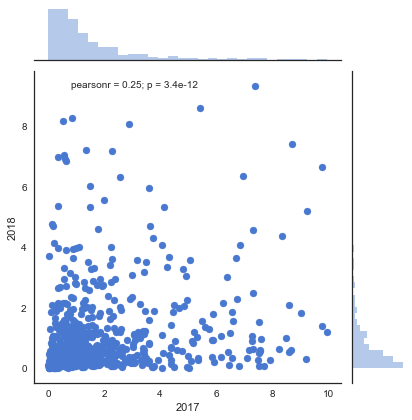

In [126]:
a=get_g(2018).rename('2018').to_frame().join(get_g(2017).rename('2017'))
sns.jointplot(data=a,x='2017',y='2018')

In [7]:
def get_gg(year):#在每年的6月决定投资组合以及投资权重
    
    eps1=eps[eps.date.dt.year==year-1].set_index('stkcd').eps
    eps2=eps[eps.date.dt.year==year-2].set_index('stkcd').eps
    eps3=eps[eps.date.dt.year==year-3].set_index('stkcd').eps
    p=ret[(ret.Trdmnt.dt.year==year)& (ret.Trdmnt.dt.month==6)].set_index('Stkcd')['Mclsprc']
    pe=p/eps1
    growth=(eps1-eps3)/eps1
    
    PEG=pe/(growth*100)
    growing=PEG[(pe>0)&(growth>0)&(PEG.notnull())]

    #return values[growing[(growing.rank(pct=True)<0.5)].index]
    return growing.sort_values(ascending=True)


C:\Users\hunzh\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


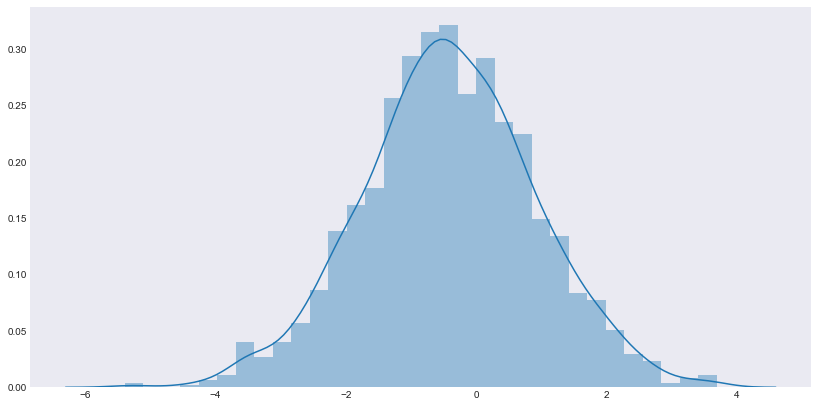

In [10]:

sns.set_style("dark")
plt.figure(figsize=(14,7))
sns.distplot(np.log(get_gg(2018)))

In [13]:
def get_g(year):#在每年的6月决定投资组合以及投资权重
    values=ret[(ret.Trdmnt.dt.year==year)& (ret.Trdmnt.dt.month==6)].set_index('Stkcd')['Msmvosd']
    equity=combas[(combas.Accper.dt.year==year-1)& (combas.Accper.dt.month==12)].set_index('Stkcd')['A003000000']
    pb=(values/equity).apply(lambda k:np.nan if k<=0 else k)
    g=pd.qcut(pb,10,labels=list(range(1,11)))
    return values[g==5]

In [386]:
get

633

In [38]:
groups={i:get_g(date.year,i) for i in range(1,11)}

In [44]:
for k,m in groups:
    print(k)

TypeError: 'int' object is not iterable

In [69]:
def get_gg(year):#在每年的6月决定投资组合以及投资权重
    values=ret[(ret.Trdmnt.dt.year==year)& (ret.Trdmnt.dt.month==6)].set_index('Stkcd')['Msmvosd']
    eps1=eps[eps.date.dt.year==year-1].set_index('stkcd').eps
    eps2=eps[eps.date.dt.year==year-2].set_index('stkcd').eps
    p=ret[(ret.Trdmnt.dt.year==year)& (ret.Trdmnt.dt.month==6)].set_index('Stkcd')['Mclsprc']
    pe=p/eps1
    growth=(eps1-eps2)/eps1
    PEG=pe/(growth*100)
    growing=PEG[(pe>0)&(growth>0)]

    return growing[growing>10]

In [107]:
use.set_index(['stkcd','date'])['ret'].drop_duplicates().unstack()

date,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,...,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00
stkcd,,,,,,,,,,,,,,,,,,,,,
000001,0.0619,-0.0113,0.0027,0.0370,-0.0551,0.0072,0.0210,-0.0411,-0.0445,0.0348,...,-0.0151,0.0387,0.1594,-0.0060,0.0564,-0.1423,-0.0954,-0.0046,-0.0618,-0.1071
000002,0.1383,0.4057,-0.1443,-0.0165,-0.0473,0.1362,0.0274,-0.0483,-0.0528,0.0671,...,0.1300,0.1032,0.0780,NaN,0.2093,-0.1294,0.0180,-0.1469,-0.0989,-0.0387
000003,0.0530,0.1458,0.1803,-0.1245,-0.0997,0.0114,NaN,NaN,-0.0622,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000004,0.5734,0.0119,0.1838,-0.0430,0.3661,0.0381,0.2618,0.1707,0.0068,-0.1572,...,0.0397,-0.0170,0.0803,-0.1244,-0.0974,0.0198,0.1092,-0.0875,0.0815,-0.1308
000005,0.3659,0.0400,0.0466,0.0167,0.0953,NaN,-0.0357,-0.0064,-0.1565,NaN,...,0.0327,-0.0634,-0.1121,NaN,NaN,-0.0521,0.0105,-0.0725,-0.0391,-0.1395
000006,0.1617,0.0491,-0.0286,0.0714,-0.0108,0.1331,0.0468,-0.1137,-0.1154,0.0429,...,0.1657,NaN,NaN,NaN,NaN,NaN,-0.2518,NaN,-0.0086,NaN
000007,0.1550,0.1591,0.2185,-0.1349,-0.0257,0.0727,NaN,NaN,0.0679,0.1175,...,0.0598,NaN,NaN,NaN,NaN,NaN,-0.1399,NaN,0.0029,-0.0176
000008,1.1267,-0.0611,-0.1429,NaN,-0.0750,0.0658,-0.1234,NaN,NaN,-0.0115,...,NaN,NaN,-0.0763,0.0318,-0.0537,-0.0870,-0.0952,NaN,-0.0715,-0.1022
000009,0.1610,0.0657,0.2968,0.0493,NaN,0.2604,NaN,NaN,-0.1384,-0.0125,...,NaN,NaN,NaN,-0.0487,-0.1231,NaN,0.0050,-0.0412,-0.0155,-0.1449


date,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,...,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00
stkcd,,,,,,,,,,,,,,,,,,,,,
000001,0.0619,-0.0113,0.0027,0.0370,-0.0551,0.0072,0.0210,-0.0411,-0.0445,0.0348,...,-0.0151,0.0387,0.1594,-0.0060,0.0564,-0.1423,-0.0954,-0.0046,-0.0618,-0.1071
000002,0.1383,0.4057,-0.1443,-0.0165,-0.0473,0.1362,0.0274,-0.0483,-0.0528,0.0671,...,0.1300,0.1032,0.0780,NaN,0.2093,-0.1294,0.0180,-0.1469,-0.0989,-0.0387
000003,0.0530,0.1458,0.1803,-0.1245,-0.0997,0.0114,NaN,NaN,-0.0622,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000004,0.5734,0.0119,0.1838,-0.0430,0.3661,0.0381,0.2618,0.1707,0.0068,-0.1572,...,0.0397,-0.0170,0.0803,-0.1244,-0.0974,0.0198,0.1092,-0.0875,0.0815,-0.1308
000005,0.3659,0.0400,0.0466,0.0167,0.0953,NaN,-0.0357,-0.0064,-0.1565,NaN,...,0.0327,-0.0634,-0.1121,NaN,NaN,-0.0521,0.0105,-0.0725,-0.0391,-0.1395
000006,0.1617,0.0491,-0.0286,0.0714,-0.0108,0.1331,0.0468,-0.1137,-0.1154,0.0429,...,0.1657,NaN,NaN,NaN,NaN,NaN,-0.2518,NaN,-0.0086,NaN
000007,0.1550,0.1591,0.2185,-0.1349,-0.0257,0.0727,NaN,NaN,0.0679,0.1175,...,0.0598,NaN,NaN,NaN,NaN,NaN,-0.1399,NaN,0.0029,-0.0176
000008,1.1267,-0.0611,-0.1429,NaN,-0.0750,0.0658,-0.1234,NaN,NaN,-0.0115,...,NaN,NaN,-0.0763,0.0318,-0.0537,-0.0870,-0.0952,NaN,-0.0715,-0.1022
000009,0.1610,0.0657,0.2968,0.0493,NaN,0.2604,NaN,NaN,-0.1384,-0.0125,...,NaN,NaN,NaN,-0.0487,-0.1231,NaN,0.0050,-0.0412,-0.0155,-0.1449


In [85]:
j1.shape

(498456,)

In [86]:
j2.shape

(498456,)

In [87]:
use[j2].shape

(1121, 6)

In [88]:
g.shape

(1142,)